Import

In [2]:
%env "WANDB_NOTEBOOK_NAME" "grd-main"
CUDA_LAUNCH_BLOCKING="1"

import os 
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc
from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer, StochasticGreedyOptimizer

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
import wandb

env: "WANDB_NOTEBOOK_NAME"="grd-main"
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parameters

In [3]:
beta = 1                                        #Parameter of greedy optimizer, default 1
sample_size = 10                                #Parameter of greedy optimizer, default 10
eps = 0.15                                      #Parameter of greedy optimizer, default 0.1
k = 20                                          #Parameter of greedy optimizer, default 5

num_epochs = 20         
batch_size = 1
learning_rate = 2e-4
momentum = 0.8

num_layers = 2
activation = 'relu'
hidden_sizes = [240]
dropout = 0.15
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

N_INFLUENCERS = 500
N_TARGETS = 500
N_FEATURES = 22
N_INSTANCES = 10
N_TRAIN = int(0.8 * N_INSTANCES)
instance_path = "instances_weibo/05-31-all_200_0.2pI_noCas_500x500/"

q1, q2, q3 = 0.2, 0.5, 0.8 #quantiles for ground_truth probabilities
low_p, med_p, high_p = 0.2, 0.5, 1 #buckets for ground_truth probabilities


WandB config

In [11]:
#wandb config
config = {
    #instances parameters
    "N_INFLUENCERS": N_INFLUENCERS,
    "N_TARGETS": N_TARGETS,
    "N_FEATURES":N_FEATURES,
    "N_INSTANCES":N_INSTANCES,
    "instance_path" : instance_path,
    
    #labels parameters
    "(q1, q2, q3)" : (q1, q2, q3),
    '(low_p, med_p, high_p)' : (low_p, med_p, high_p),

    #greedy parameters
    "beta" : beta,               
    "sample_size" : sample_size,      
    "eps" : eps,              
    "k" : k,             

    #ML parameters
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "momentum": momentum,
    "batch_size": batch_size,
    "num_layers" : num_layers,
    "activation" : activation,
    "hidden_sizes" : hidden_sizes,
    "dropout" : dropout,
    "labels" : "DB" }

wandb.init(project="influence-maximization", entity="mario-michelessa", config=config)
# wandb.config = config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mario-michelessa (use `wandb login --relogin` to force relogin)


Device

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


wandb.config.update({"device":device})

Using device: cuda
GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Preprocessing

Instances definition

In [13]:

def transform_Y(Y) : 
    Yc = np.copy(Y)
    #return np.minimum(100 * Y_train, np.ones((N_TRAIN, N_INFLUENCERS, N_TARGETS)))
    t1 = np.quantile(Y[Y>0], q1) # weak probability
    t2 = np.quantile(Y[Y>0], q2) # medium probability
    t3 = np.quantile(Y[Y>0], q3) # high probability
    Y[Yc>0] = 0.1
    Y[Yc>t1] = low_p
    Y[Yc>t2] = med_p
    Y[Yc>t3] = high_p
    return Y  

softmax = lambda x : np.exp(x)/np.sum(np.exp(x))

def transform_Yemb(Y, a) :
    # Y.apply_(lambda x : np.exp(a*x))
    # Y.apply_(lambda x : 1/(1+np.exp(-a*x)))
    for instance in range(Y.shape[0]) : 
        Y[instance] = np.apply_along_axis(lambda x:x-abs(max(x)), 1, Y[instance]) 
        Y[instance] = np.apply_along_axis(softmax, 1, Y[instance])
        Y[instance] = np.around(Y[instance],3)
        Y[instance] = np.abs(Y[instance])/np.max(Y[instance])
    return Y
    return torch.min(torch.ones_like(Y), a * Y)

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))
    
    Yemb_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    Yemb_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))
    
    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(instance_path + f"{instance}.npz")['arr_0']
        if instance in train_id :

            #when no embedding labels
            # X_train[c_train] = XY[:,:,:-1]
            # Y_train[c_train] = XY[:,:,-1]
            X_train[c_train] = XY[:,:,:-2]
            Y_train[c_train] = XY[:,:,-2]
            Yemb_train[c_train] = XY[:,:,-1]
            c_train += 1
        
        else : 
            # X_test[c_test] = XY[:,:,:-1]
            # Y_test[c_test] = XY[:,:,-1]
            X_test[c_test] = XY[:,:,:-2]
            Y_test[c_test] = XY[:,:,-2]
            Yemb_test[c_test] = XY[:,:,-1]
            c_test += 1
    
    #Cheating line
    #X_train[:,:,:,9] = Y_train * 2
    
    Y_train = transform_Y(Y_train)
    Y_test = transform_Y(Y_test)

    Yemb_train = transform_Yemb(Yemb_train, 1)
    Yemb_test = transform_Yemb(Yemb_test, 1)

    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    Yemb_train = torch.from_numpy(Yemb_train).float()

    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    Yemb_test = torch.from_numpy(Yemb_test).float()

    Yemb_train = torch.min(torch.ones_like(Yemb_train), Yemb_train)
    Yemb_test = torch.min(torch.ones_like(Yemb_test), Yemb_test)

    # test on random dense labels
    #Y_train = torch.bernoulli(torch.zeros(Y_train.size()),0.1)
    #Y_test = torch.bernoulli(torch.zeros(Y_test.size()),0.1)
    
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    return X_train, Y_train, X_test, Y_test, Yemb_train, Yemb_test

Dataset

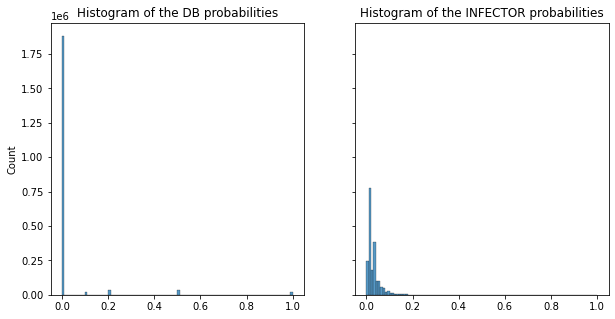

In [14]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)

# X_train, Yemb_train, X_test, Yemb_test, Y_train, Y_test = create_train_test(train_id)
X_train, Y_train, X_test, Y_test, Yemb_train, Yemb_test = create_train_test(train_id)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey=True)
sns.histplot(Y_train.flatten(), ax = ax[0], bins=100)
ax[0].set_title("Histogram of the DB probabilities")
sns.histplot(Yemb_train.flatten(), ax = ax[1], bins=100)
ax[1].set_title("Histogram of the INFECTOR probabilities")
plt.show()

Print training

In [15]:
def print_training(loss, train, test, train_dni, test_dni, title = "") : 

    fig, ax = plt.subplots(1,3, figsize = (15,5))
    plt.suptitle(title)
    ax[0].plot(loss)
    ax[0].set_title('Learning curve')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')

    ax[1].plot(train, label="train_scores")
    ax[1].plot(test, label="test_scores")
    ax[1].set_title('Quality')
    ax[1].set_ylabel('expected #influenced')
    ax[1].set_xlabel('epoch')
    ax[1].legend()

    ax[2].plot(train_dni, label="train_scores")
    ax[2].plot(test_dni, label="test_scores")
    ax[2].set_title('data-based quality')
    ax[2].set_ylabel('different nodes influenced')
    ax[2].set_xlabel('epoch')
    ax[2].legend()
    plt.show()


Evaluation function

In [16]:
def dni(seeds, Y) : 
    """
    estimates the number of Different Nodes Infected given a seed set and a DATA-BASED label. 
        If a data-based label of (u,v) is positive, it means that v appears in at least one cascade of u
    for each column(target) if one of the labels is >0 then it appears in a cascade provoqued by one of the seeds
    """
    return (Y[seeds,:].sum(dim=0) > 0).sum().item() 

def eval_dni(net, X, Y):
    """
    input : X[instances, nI, nT, nF], Y[instances, nI, nT]
    estimates number of different nodes infected based on the cascades
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([  dni(    greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1]    ,Y[i]) for i in range(X.shape[0])])
    return float(result) #float is here to delete the gradient if there is a torch gradient

def eval_grd(net, X, Y):
    """
    estimates expectation of dni in the bipartite graph: sum(1-prod(1-p_uv))
    """
    X = X.to(device)
    Y = Y.to(device)
    # print(np.mean([greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1].__len__() for i in range(X.shape[0])]))
    result = np.mean([    set_func(   greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])
    return float(result)

def eval_loss(net, X, Y, loss):
    """
    validation loss
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([np.sum( ( net(X[i,:,:,:]).view_as(Y[0]) - Y[i, :, :] ).cpu().detach().numpy() **2. ) for i in range(X.shape[0])])
    return float(result)

def eval_rnd(X, Y):
    """
    Randomly selects seeds and computes influence
    """
    X = X.to(device)
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

Random

In [78]:
k=20
rd_score_xtrain = np.mean([eval_rnd(X_train, Y_train) for _ in range(10)])
rd_score_xtest = np.mean([eval_rnd(X_test, Y_test) for _ in range(10)])
print(f"Average random score X_train : {rd_score_xtrain}")
print(f"Average random score X_test : {rd_score_xtest}")

wandb.log({"rd_score_xtrain" : rd_score_xtrain})
wandb.log({"rd_score_xtest" : rd_score_xtest})

Average random score X_train : 189.7482597351074
Average random score X_test : 191.16866607666014


### Decision focused

Model definition

In [18]:
train_scores_df = []
test_scores_df  = []
train_dni_df = []
test_dni_df  = []
loss_df = []
seeds_df = []

net_df = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout)
net_df.apply(init_weights)
net_df = net_df.to(device)
#net = net.half()
net_df.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=22, out_features=240, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.15, inplace=False)
  (3): Linear(in_features=240, out_features=1, bias=True)
  (4): Hardtanh(min_val=0, max_val=1.0)
)>

Training

In [25]:

print("epoch | loss | train_score | test_score | train_dni | test_dni")

optimizer = torch.optim.Adam(net_df.parameters(), lr = learning_rate, betas = (momentum, 0.999))
marginal_vec_pred = partial(marginal_vec, w = w)

for epoch in range(num_epochs):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            
            true_set_func = partial(set_func, P = P, w = w)
            pred = net_df(X).view_as(P)                
            fn = GreedyOptimizer.apply
            loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta)
            # del(X)
            del(P)
        
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_score = eval_grd(net_df, X_train, Y_train)
    test_score  = eval_grd(net_df, X_test, Y_test)
    
    train_dni = eval_dni(net_df, X_train, Y_train)
    test_dni  = eval_dni(net_df, X_test, Y_test)

    print(torch.mean(net_df(X)))

    loss_df.append(loss.item())

    wandb.log({ "epoch_df" : len(loss_df), 
                "loss_df" : loss.item(), 
                "train_score_df" : train_score, 
                "test_score_df" : test_score,
                "train_dni_df" : train_dni, 
                "test_dni_df" : test_dni},)
    
    print(f"{len(loss_df)} | {loss.item()} | {train_score} | {test_score} | {train_dni} | {test_dni}")

    train_scores_df.append(train_score)
    test_scores_df.append(test_score)
    train_dni_df.append(train_dni)
    test_dni_df.append(test_dni)


epoch | loss | train_score | test_score | train_dni | test_dni
tensor(0.0118, grad_fn=<MeanBackward0>)
41 | -289.2472839355469 | 289.4438705444336 | 290.97113037109375 | 394.0 | 388.0
tensor(0.0087, grad_fn=<MeanBackward0>)
42 | -288.17840576171875 | 290.1797904968262 | 289.24359130859375 | 393.75 | 387.0
tensor(0.0049, grad_fn=<MeanBackward0>)
43 | -286.2951354980469 | 291.21939849853516 | 288.1890106201172 | 393.25 | 385.5
tensor(0.0050, grad_fn=<MeanBackward0>)
44 | -285.210693359375 | 289.28263092041016 | 289.05921936035156 | 392.75 | 385.5
tensor(0.0142, grad_fn=<MeanBackward0>)
45 | -290.4484558105469 | 287.41427993774414 | 289.3138732910156 | 393.25 | 386.5
tensor(0.0198, grad_fn=<MeanBackward0>)
46 | -289.5679626464844 | 289.65966033935547 | 292.22755432128906 | 394.5 | 393.5
tensor(0.0237, grad_fn=<MeanBackward0>)
47 | -294.3645324707031 | 287.82524490356445 | 295.01612854003906 | 392.25 | 386.0
tensor(0.0222, grad_fn=<MeanBackward0>)
48 | -292.3829040527344 | 290.342613220214

Plot Curve

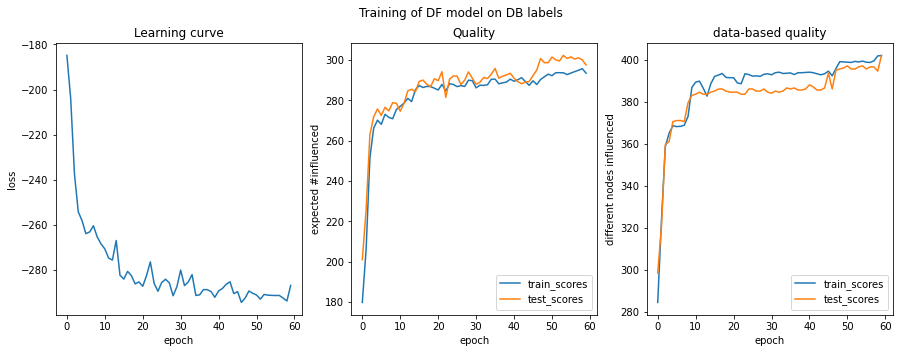

In [26]:
print_training(loss_df, train_scores_df, test_scores_df,train_dni_df, test_dni_df, "Training of DF model on DB labels")

### Stochastic Greedy

In [13]:
train_scores_st = []
test_scores_st  = []
train_dni_st = []
test_dni_st  = []
loss_st = []
seeds_st = []

net_st = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout)
net_st.apply(init_weights)
net_st = net_st.to(device)
net_st.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=22, out_features=240, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.15, inplace=False)
  (3): Linear(in_features=240, out_features=1, bias=True)
  (4): Hardtanh(min_val=0, max_val=1.0)
)>

In [18]:
print("epoch | loss | train_score | test_score | train_dni | test_dni")

optimizer = torch.optim.Adam(net_st.parameters(), lr = learning_rate, betas = (momentum, 0.999))
marginal_vec_pred = partial(marginal_vec, w = w)
optimizer = torch.optim.Adam(net_st.parameters(), lr = learning_rate)

softmax = torch.nn.Softmax(dim = -1)

def partial_marginal_vec(S, U, P, w):
    #assume S \cap U to be empty
    w = torch.Tensor(w)
    return torch.mv(P[U], w * torch.prod(1 - P[S], axis = 0))
partial_marginal_vec_pred = partial(partial_marginal_vec, w = w)

nk = N_INFLUENCERS
for epoch in range(10):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            true_set_func = partial(set_func, P = P, w = w)
            pred = net_st(X).view_as(P)

            fn = StochasticGreedyOptimizer.apply
            loss -= fn(pred, true_set_func, partial_marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta, nk)
            # del(X)
            del(P)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_score = eval_grd(net_st, X_train, Y_train)
    test_score  = eval_grd(net_st, X_test, Y_test)
    
    train_dni = eval_dni(net_st, X_train, Y_train)
    test_dni  = eval_dni(net_st, X_test, Y_test)

    print(torch.mean(net_st(X)))

    loss_st.append(loss.item())

    wandb.log({ "epoch_st" : len(loss_st), 
                "loss_st" : loss.item(), 
                "train_score_st" : train_score, 
                "test_score_st" : test_score,
                "train_dni_st" : train_dni, 
                "test_dni_st" : test_dni},)
    
    print(f"{len(loss_st)} | {loss.item()} | {train_score} | {test_score} | {train_dni} | {test_dni}")

    train_scores_st.append(train_score)
    test_scores_st.append(test_score)
    train_dni_st.append(train_dni)
    test_dni_st.append(test_dni)
        
 

epoch | loss | train_score | test_score | train_dni | test_dni
tensor(0.0064, grad_fn=<MeanBackward0>)
21 | -326.6392517089844 | 311.90581130981445 | 319.771728515625 | 405.375 | 415.5
tensor(0.0062, grad_fn=<MeanBackward0>)
22 | -323.54248046875 | 314.13137435913086 | 322.27435302734375 | 406.625 | 412.5
tensor(0.0058, grad_fn=<MeanBackward0>)
23 | -329.0785217285156 | 316.3378257751465 | 326.245361328125 | 409.125 | 412.5
tensor(0.0047, grad_fn=<MeanBackward0>)
24 | -327.10260009765625 | 317.11148834228516 | 328.09820556640625 | 408.5 | 420.0
tensor(0.0035, grad_fn=<MeanBackward0>)
25 | -327.8370056152344 | 316.43141174316406 | 327.7316131591797 | 407.5 | 421.0
tensor(0.0071, grad_fn=<MeanBackward0>)
26 | -327.65606689453125 | 318.08270263671875 | 328.9167938232422 | 408.625 | 414.5
tensor(0.0066, grad_fn=<MeanBackward0>)
27 | -328.7828063964844 | 319.23987197875977 | 328.54119873046875 | 408.5 | 415.5
tensor(0.0040, grad_fn=<MeanBackward0>)
28 | -328.1762390136719 | 317.364013671875

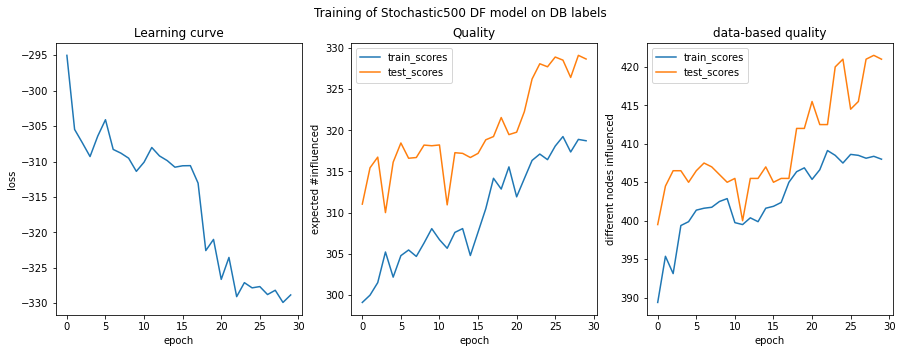

In [19]:
print_training(loss_st, train_scores_st, test_scores_st, train_dni_st, test_dni_st, f"Training of Stochastic{nk} DF model on DB labels")

### 2 Stage

Model definiton

In [47]:

train_scores_2s = []
test_scores_2s  = []
train_dni_2s = []
test_dni_2s  = []
loss_2s = []
val_loss_2s = []

net_2s = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout=dropout)
net_2s.apply(init_weights)
net_2s = net_2s.to(device)
print(net_2s.modules)

loss_fn = nn.MSELoss()
def loss_unbalanced(pred, P) : 
    """
    to counter the sparsity of the data, when the model predicts lower probabilities than the ground truth, the loss is higher
    """
    # neg = pred < P
    # pos = pred > P
    # return 100 * loss_fn(pred[neg], P[neg]) + loss_fn(pred[pos],P[pos])
    phi = 0.5
    return torch.sum(torch.exp(phi * (P - pred)) - phi * (P-pred) - 1)

optimizer = torch.optim.Adam(net_2s.parameters(), lr = learning_rate)
# optimizer = torch.optim.SGD(net_2s.parameters(), lr = 0.1)

<bound method Module.modules of Sequential(
  (0): Linear(in_features=22, out_features=240, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.15, inplace=False)
  (3): Linear(in_features=240, out_features=1, bias=True)
  (4): Hardtanh(min_val=0, max_val=1.0)
)>


Training

In [50]:

print("epoch | loss | val loss | train_score | test_score | train_dni | test_dni")

for epoch in range(30):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, ) #shuffle=True 
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net_2s(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(net_2s.parameters(), 1.)
        optimizer.step()
    
    print(torch.mean(net_df(X)))

    val_loss = eval_loss(net_2s, X_test, Y_test, loss_fn)
    train_score = eval_grd(net_2s, X_train, Y_train)
    test_score  = eval_grd(net_2s, X_test, Y_test)
    train_dni = eval_dni(net_2s, X_train, Y_train)
    test_dni  = eval_dni(net_2s, X_test, Y_test)
    print(f"{len(loss_2s)} | {loss} | {val_loss} | {train_score} | {test_score} | {train_dni} | {test_dni}" )   

    train_scores_2s.append(train_score)
    test_scores_2s.append(test_score)     
    train_dni_2s.append(train_dni)
    test_dni_2s.append(test_dni)     
    val_loss_2s.append(val_loss)
    loss_2s.append(loss.item())

    wandb.log({ "epoch_2s" : len(loss_2s), 
                "loss_2s" : loss.item(), 
                "val_loss_2s" : val_loss,
                "train_score_2s" : train_score, 
                "test_score_2s" : test_score,
                "train_dni_2s" : train_dni, 
                "test_dni_2s" : test_dni})

epoch | loss | val loss | train_score | test_score | train_dni | test_dni
tensor(0.0206, grad_fn=<MeanBackward0>)
30 | 0.016970617696642876 | 4096.13134765625 | 290.8779411315918 | 295.3104248046875 | 401.375 | 405.5
tensor(0.0206, grad_fn=<MeanBackward0>)
31 | 0.016958126798272133 | 4092.328125 | 290.46053314208984 | 295.3104248046875 | 405.375 | 403.5
tensor(0.0206, grad_fn=<MeanBackward0>)
32 | 0.016937417909502983 | 4088.26708984375 | 291.6771125793457 | 295.3104248046875 | 409.125 | 405.0
tensor(0.0206, grad_fn=<MeanBackward0>)
33 | 0.016926072537899017 | 4085.20703125 | 294.060791015625 | 293.8830261230469 | 409.125 | 403.5
tensor(0.0206, grad_fn=<MeanBackward0>)
34 | 0.01691163331270218 | 4081.958984375 | 295.64029693603516 | 294.8386688232422 | 411.75 | 405.0
tensor(0.0206, grad_fn=<MeanBackward0>)
35 | 0.016899654641747475 | 4079.020263671875 | 297.0133056640625 | 297.6534118652344 | 410.75 | 405.5
tensor(0.0206, grad_fn=<MeanBackward0>)
36 | 0.016890328377485275 | 4076.951171

Plot Curve

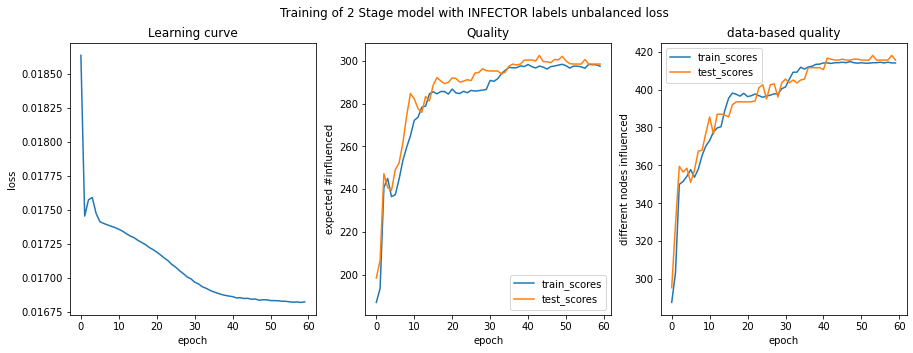

In [51]:
print_training(loss_2s, train_scores_2s, test_scores_2s, train_dni_2s, test_dni_2s,"Training of 2 Stage model with INFECTOR labels unbalanced loss")


### Hyperparameter tuning

Sweep df

In [ ]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep df - various hp - db labels",
  "early_terminate":{
    "type": "hyperband",
    "min_iter": 3},
  "method" : "bayes",
  "metric":{
    "name": "test_dni_df",
    "goal": "maximize",},

  "parameters" : {
    #Varying parameters
    "eps" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 0.2},
    "learning_rate" : {"distribution" : "log_uniform_values", "min" : 1e-4, "max" : 1e-2},
    "momentum" : {"distribution" : "log_uniform_values", "min" : 0.8, "max" : 1.},
    "dropout" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 1.},
    "layer_size" : {"min" : 50, "max" : 250},
    "sample_size" : {"min" : 1, "max" : 50},

    #instances parameters
    "N_INFLUENCERS": {"value" : N_INFLUENCERS},
    "N_TARGETS": {"value" : N_TARGETS},
    "N_FEATURES":{"value" : N_FEATURES},
    "N_INSTANCES":{"value" : N_INSTANCES},
    "instance_path" : {"value" : instance_path},
    "labels" : {"value" : "data-based}"},

    #labels parameters

    #greedy parameters
    "beta" :{ "value" : beta},                 
    "k" : {"value" : k},             

    #ML parameters
    "epochs": {"value" : 60},
    "batch_size": {"value" : batch_size},
    "num_layers" : {"value" : num_layers},
    "activation" : {"value" : activation},
    
  }
}
    
def train_df():
  with wandb.init() as run:
    config = wandb.config
    loss_df = []
    net_df = make_fc(config["N_FEATURES"], config["num_layers"], config["activation"], [config["layer_size"]], dropout=config["dropout"])
    net_df.apply(init_weights)
    net_df = net_df.to(device)
      
    optimizer = torch.optim.Adam(net_df.parameters(), lr = config["learning_rate"], betas = (config["momentum"], 0.999))
    marginal_vec_pred = partial(marginal_vec, w = w)

    for _ in range(60):
        
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = config["batch_size"])
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X = X.to(device)
                P = P.to(device)
                
                true_set_func = partial(set_func, P = P, w = w)
                pred = net_df(X).view_as(P)                
                fn = GreedyOptimizer.apply
                loss -= fn(pred, true_set_func, marginal_vec_pred, config["N_INFLUENCERS"],  config["k"],  config["eps"], config["sample_size"], config["beta"])
                del(X)
                del(P)
            
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_score = eval_grd(net_df, X_train, Y_train)
        test_score  = eval_grd(net_df, X_test, Y_test)
        
        train_dni = eval_dni(net_df, X_train, Y_train)
        test_dni  = eval_dni(net_df, X_test, Y_test)

        loss_df.append(loss.item())

        wandb.log({ "epoch_df" : len(loss_df), 
                    "loss_df" : loss.item(), 
                    "train_score_df" : train_score, 
                    "test_score_df" : test_score,
                    "train_dni_df" : train_dni, 
                    "test_dni_df" : test_dni},)


In [ ]:
count = 40 # number of runs to execute
sweep_df = wandb.sweep(sweep_config)
wandb.agent(sweep_df, function=train_df, count=count, project='influence-maximization')

Sweep 2 stage

In [ ]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep 2s - various hp - infector labels",
  "early_terminate":{
    "type": "hyperband",
    "min_iter": 3},
  "method" : "bayes",
  "metric":{
    "name": "test_dni_2s",
    "goal": "maximize",},

  "parameters" : {
    #Varying parameters
    "phi" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 0.2},
    "learning_rate" : {"distribution" : "log_uniform_values", "min" : 1e-4, "max" : 1e-2},
    "momentum" : {"distribution" : "log_uniform_values", "min" : 0.8, "max" : 1.},
    "dropout" : {"distribution" : "log_uniform_values", "min" : 0.01, "max" : 1.},
    "layer_size" : {"min" : 50, "max" : 300},
    "sample_size" : {"min" : 1, "max" : 50},

    #instances parameters
    "N_INFLUENCERS": {"value" : N_INFLUENCERS},
    "N_TARGETS": {"value" : N_TARGETS},
    "N_FEATURES":{"value" : N_FEATURES},
    "N_INSTANCES":{"value" : N_INSTANCES},
    "instance_path" : {"value" : instance_path},
    "labels" : {"value" : "infector}"},
     
    "k" : {"value" : k},             

    #ML parameters
    "epochs": {"value" : 30},
    "batch_size": {"value" : batch_size},
    "num_layers" : {"value" : num_layers},
    "activation" : {"value" : activation},
    
  }
}

def train_2s():
  with wandb.init() as run:
    config = wandb.config
    loss_2s = []

    net_2s = make_fc(config["N_FEATURES"], config["num_layers"], config["activation"], [config["layer_size"]], dropout=config["dropout"])
    net_2s.apply(init_weights)
    net_2s = net_2s.to(device)

    optimizer = torch.optim.Adam(net_2s.parameters(), lr = config["learning_rate"], betas = (config["momentum"], 0.999))

    for epoch in range(config["epochs"]):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = config["batch_size"])
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X, P = X.to(device), P.to(device)
                pred = net_2s(X).view_as(P)
                loss += loss_unbalanced(pred, P)
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_score = eval_grd(net_2s, X_train, Y_train)
        test_score  = eval_grd(net_2s, X_test, Y_test)
        
        train_dni = eval_dni(net_2s, X_train, Yemb_train)
        test_dni  = eval_dni(net_2s, X_test, Yemb_test)

        loss_2s.append(loss.item())

        wandb.log({ "epoch_2s" : len(loss_2s), 
                    "loss_2s" : loss.item(), 
                    "train_score_2s" : train_score, 
                    "test_score_2s" : test_score,
                    "train_dni_2s" : train_dni, 
                    "test_dni_2s" : test_dni},)

In [ ]:
count = 40 # number of runs to execute
sweep_2s = wandb.sweep(sweep_config)
wandb.agent(sweep_2s, function=train_2s, count=count, project='influence-maximization')

### Sweep nk

In [11]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep st - nk - db labels",
  "early_terminate":{
    "type": "hyperband",
    "min_iter": 3},
  "method" : "random",
  # "metric":{
  #   "name": "test_dni_st",
  #   "goal": "maximize",},

  "parameters" : {
    #Varying parameters
    "nk" : {"min" : 10, "max" : 500},
    "eps" : {"value" : 0.15},
    "learning_rate" : {"value" : 2e-4},
    "momentum" : {"value" : 0.8},
    "dropout" : {"value" : 0.15},
    "layer_size" : {"value" : 240},
    "sample_size" : {"value" : 10},

    #instances parameters
    "N_INFLUENCERS": {"value" : N_INFLUENCERS},
    "N_TARGETS": {"value" : N_TARGETS},
    "N_FEATURES":{"value" : N_FEATURES},
    "N_INSTANCES":{"value" : N_INSTANCES},
    "instance_path" : {"value" : instance_path},
    "labels" : {"value" : "data-based}"},

    #labels parameters

    #greedy parameters
    "beta" :{ "value" : beta},                 
    "k" : {"value" : k},             

    #ML parameters
    "epochs": {"value" : 20},
    "batch_size": {"value" : batch_size},
    "num_layers" : {"value" : num_layers},
    "activation" : {"value" : activation},
    
  }
}
  
def train_st():
  with wandb.init() as run:
    config = wandb.config
    loss_st = []
    net_st = make_fc(config["N_FEATURES"], config["num_layers"], config["activation"], [config["layer_size"]], dropout=config["dropout"])
    net_st.apply(init_weights)
    net_st = net_st.to(device)
      
    optimizer = torch.optim.Adam(net_st.parameters(), lr = config["learning_rate"], betas = (config["momentum"], 0.999))

    def partial_marginal_vec(S, U, P, w):
        #assume S \cap U to be empty
        w = torch.Tensor(w)
        return torch.mv(P[U], w * torch.prod(1 - P[S], axis = 0))
    partial_marginal_vec_pred = partial(partial_marginal_vec, w = w)

    for _ in range(30):
        
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = config["batch_size"])
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X = X.to(device)
                P = P.to(device)
                
                true_set_func = partial(set_func, P = P, w = w)
                pred = net_st(X).view_as(P)                
                fn = StochasticGreedyOptimizer.apply
                loss -= fn(pred, true_set_func, partial_marginal_vec_pred, config["N_INFLUENCERS"],  config["k"],  config["eps"], config["sample_size"], config["beta"], config["nk"])
                del(X)
                del(P)
            
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_score = eval_grd(net_st, X_train, Y_train)
        test_score  = eval_grd(net_st, X_test, Y_test)
        
        train_dni = eval_dni(net_st, X_train, Y_train)
        test_dni  = eval_dni(net_st, X_test, Y_test)

        loss_st.append(loss.item())

        wandb.log({ "epoch_st" : len(loss_st), 
                    "loss_st" : loss.item(), 
                    "train_score_st" : train_score, 
                    "test_score_st" : test_score,
                    "train_dni_st" : train_dni, 
                    "test_dni_st" : test_dni},)


In [13]:
count = 40 # number of runs to execute
sweep_st = wandb.sweep(sweep_config)
wandb.agent(sweep_st, function=train_st, count=count, project='influence-maximization')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: dgpbt6nd
Sweep URL: https://wandb.ai/mario-michelessa/influence-maximization/sweeps/dgpbt6nd


wandb: Agent Starting Run: beo7z8mw with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 332
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▆▆▅▅▅▄▄▄▃▁▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
test_dni_st,▁▂▁▁▁▃▃▃▃▄▆▄█▇▇▆▃▇███▇▇▇▅▇██▇▇
test_score_st,▂▂▁▂▂▁▂▂▃▆▆▆▆▆▆▆▆▆█▇▇▆▇▆▆████▆
train_dni_st,▃▁▃▃▄▅▅▅▅▅▆▆█▇▇▆▆▇█▇▇▇▇▇▇▇████
train_score_st,▂▁▂▂▃▂▃▄▅▅▇▇▇▇▇▇▇████▇████████
epoch_st,30
loss_st,-328.89474
test_dni_st,405.0
test_score_st,303.8568
train_dni_st,407.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qkn4696f with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 116
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▇▇▇▆▇▆▇█▅▂▂▃▂▂▃▂▂▁▂▂▂▂▂▂▁▂▂▂▂
test_dni_st,▁▁▄▆▄▆▆▃▁▄▆▇▇██████▇█▇████▇█▇▇
test_score_st,▁▁▂▂▄▃▃▃▂▇█▆▆▇█▇▇▇▇▆▇█▇▇▇█▇▇▇▆
train_dni_st,▁▃▄▄▄▅▅▄▄▄▇▇▇▇▇▇█▇█▇█▇▇███████
train_score_st,▂▁▃▃▃▃▃▄▄▅▇▆▇█▇▇▇███▇▇█▇█▇█▇▇█
epoch_st,30
loss_st,-325.10666
test_dni_st,408.0
test_score_st,305.10036
train_dni_st,413.875


wandb: Agent Starting Run: ed0equc2 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 479
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▇▇▇▆▆▆▆▅▆▆▅▅▅▅▅▄▃▄▃▂▂▁▁▁▁▂▁▁▁
test_dni_st,▂▂▅▄▂▅▂▅▁▅▅▅▁▁▁▆▆▇▇▇▇▇▇▇█▇▇▇█▇
test_score_st,▄▁▁▁▂▃▃▁▃▃▁▃▃▁▄█▅▇▅▆▆▆███▆▅▆██
train_dni_st,▁▂▂▃▂▄▄▃▃▃▃▃▃▃▃▄▅▇▆▇▇█▇▇▇▇▇█▇▇
train_score_st,▁▂▂▃▂▃▃▃▃▄▄▄▄▄▅▄▆▇▆▇▇▇████▇███
epoch_st,30
loss_st,-329.6521
test_dni_st,407.5
test_score_st,309.42134
train_dni_st,408.25


wandb: Agent Starting Run: sftdrrmx with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 422
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▆▅▅▄▄▄▄▄▃▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
test_dni_st,▁▁▃▃▃▃▃▃▃▄▅▅▇█▇▅▇▇█▇▇██▇█▇▇▆█▇
test_score_st,▁▂▁▁▂▂▁▁▂▄▂▅▆█▅▆█▇▇▆▇▇▇▇▇▆▆▅▇▇
train_dni_st,▁▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▆▇▇▇█▇███████
train_score_st,▁▂▂▂▃▃▃▃▄▅▅▅▆▇▇▇▇▇█▇▇█████▇███
epoch_st,30
loss_st,-329.95322
test_dni_st,406.5
test_score_st,308.23204
train_dni_st,413.25


wandb: Agent Starting Run: qtgsbeax with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 485
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▆▆▅▅▅▄▄▄▃▄▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
test_dni_st,▁▁▁▃▃▃▄▄▃▃▃▆▇▅▆▇▃███▇█▇▇▇▇▇█▇█
test_score_st,▁▂▂▂▂▂▁▂▅▃▃▆▆▆▄▆▇██████▆▇▇▇█▇▇
train_dni_st,▁▂▃▃▃▄▄▅▄▄▄▅▆▆▇▇▆▆▇▇▇██▇▇▇▇█▇▇
train_score_st,▂▁▁▂▂▂▂▃▅▅▅▅▇▆▆▇▇▇███▇█▇▇█▇███
epoch_st,30
loss_st,-329.10217
test_dni_st,408.0
test_score_st,305.98645
train_dni_st,411.625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 12n413pp with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 266
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▇▅▅▅▄▄▄▄▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_st,▁▂▁▅▁▅▆▅▃██▇▇▇▆▇▆▇▇▇█▇▇▇▇▇▆▇█▇
test_score_st,▂▁▁▃▁▂▅▄▄█▇▆▇▆▇█▇▆██▇██▇█▇▆▆▇▆
train_dni_st,▁▂▃▃▃▃▄▅▄▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
train_score_st,▁▂▂▂▃▄▄▄▅█▇▇▇████▇████▇▇██████
epoch_st,30
loss_st,-329.952
test_dni_st,407.5
test_score_st,303.33784
train_dni_st,412.25


wandb: Agent Starting Run: n9cmxtvn with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 495
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▅▄▄▄▄▄▄▄▃▃▃▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
test_dni_st,▁▆▅▄▅▅▇▃▄▆▇▇▇▇▇██▆▇▇███▇▇█▇███
test_score_st,▁▄▆▃▃▄▄▂▂▂▅▅▇▇██▆▆▇█▇██▇▇█▇▇▇█
train_dni_st,▁▃▅▅▅▅▅▅▆▆▅▆▆▇▇▇█▇▇███████████
train_score_st,▁▂▄▅▄▅▅▄▄▄▅▆▇▇▇▇▇▆▇▇██████████
epoch_st,30
loss_st,-329.93289
test_dni_st,409.0
test_score_st,307.63327
train_dni_st,412.25


wandb: Agent Starting Run: 2dratenf with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 249
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▅▅▄▅▅▅▅▄▃▃▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂
test_dni_st,▁▁▁▅▃▆▇▆▆▆▇█▇█▇▆▇▇▇▇██▇▇█▇▇███
test_score_st,▂▁▁▃▄▄▄▃▄▄▇▇█▇▇▇▆▇█▇▇▇▇▇▇▇█▇█▇
train_dni_st,▁▂▃▄▅▄▅▄▄▆▆▇▇████▇▇▇█████▇██▇█
train_score_st,▁▂▂▃▃▃▃▄▄▄▆▇▆▇██▇████████▇█▇██
epoch_st,30
loss_st,-326.44534
test_dni_st,408.5
test_score_st,306.53194
train_dni_st,413.375


wandb: Agent Starting Run: brq8xag0 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 253
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▅▅▅▅▅▅▅▄▆▃▃▂▂▂▁▁▁▁▁▁▁▂▂▁▂▁▁▂▂
test_dni_st,▁▁▁▂▆▄▇▆█▅▇▆▇▇▆▇▇▄▇▇▇▇▆▆▆▇▇▇▆▇
test_score_st,▄▁▂▄▂▄▄▄▅▁█▇▇▅▆█▇▇▇▇▇▇▆▆▆▇▇▆▆▆
train_dni_st,▁▃▃▄▅▅▅▆▆▆▇▆███████████▇████▇█
train_score_st,▁▂▃▃▄▄▄▄▅▄▆▆▇▇▇█████████████▇█
epoch_st,30
loss_st,-327.20883
test_dni_st,406.5
test_score_st,302.93607
train_dni_st,411.75


wandb: Agent Starting Run: a71c2ip0 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 91
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▅▆▅▅▄▅▄▄▄▅▅▂▃▂▂▂▂▁▂▂▁▂▂▂▃▂▁▁
test_dni_st,▁▅▅▃▇▆▆▇▆▆█▅▅▆▇▇▇▆▆▆▆▆▆▆▇▆▆▇▇▇
test_score_st,▂▁▁▁▄▄▄▅▅▅▆▂▄▆▆▆█▇▇▆▇██▇▇▆▆███
train_dni_st,▁▂▃▃▃▄▄▄▅▆▆▆▆███▇▇▇▇▇▆▇▇▇▇▇▇▆▇
train_score_st,▁▂▂▂▃▃▃▄▄▅▆▂▄▇▇▇███▇▇██▇██████
epoch_st,30
loss_st,-328.19879
test_dni_st,408.0
test_score_st,307.75505
train_dni_st,410.75


wandb: Agent Starting Run: hw9suyq4 with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 82
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▅▅▅▅▅▄▃▃▃▂▂▂▃▃▁▁▂▂▂▂▁▁▁▂▁▂▂▂
test_dni_st,▁▁▁▅▅▅▅▄▆▇▇██▇▆▆▆▆▅▆▆▆▆▆▆▆▇▆▆▆
test_score_st,▃▁▁▃▂▅▄▄▇▅▅▅▅▅▆▆▆▇▆▆▆▇▇██▇▇███
train_dni_st,▁▂▂▄▄▄▄▃▅▇▇▇█▆▆▆▅▅▅▅▅▆▅▆▆▆▆▆▅▆
train_score_st,▁▃▂▃▄▅▅▅▇▆▅▇▇▇▇████▇▇▇█████▇██
epoch_st,30
loss_st,-323.54089
test_dni_st,408.5
test_score_st,311.94249
train_dni_st,411.375


wandb: Agent Starting Run: v4p5an9k with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 49
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,██▅▅▄▄▄▃▃▃▃▄▃▃▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁
test_dni_st,▄▂▁▃▃▃▃▃▃▅▆▆▇▆▆▇▇█▇▆▄▆▆▆▆▆▆▆▇▇
test_score_st,▂▁▁▁▂▂▃▁▁▃▅▅▆▆▇▇▆▅▇▇▇▇▆▆▇▇▇▇█▇
train_dni_st,▁▃▂▄▄▅▅▅▅▅▅▅▆▅▆▇▆█▇▇▆▆▆▆▆▆▆▆▆▆
train_score_st,▁▂▃▂▃▄▄▄▄▅▄▄▅▅▇▇▆▇▇▇▇▇▇▇██▇█▇█
epoch_st,30
loss_st,-317.51791
test_dni_st,408.5
test_score_st,308.20706
train_dni_st,407.5


wandb: Agent Starting Run: eahsxfkx with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 371
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▇▅▅▅▅▅▅▅▄▂▃▃▅▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
test_dni_st,▁▂▁▂▂▂▆▂▆▆▇████████████▇▇█▇▇▇█
test_score_st,▂▂▁▂▂▄▂▄▂▄▅▇▇▆▆▇▇▇███▇▇▇▆▇▇▆▅█
train_dni_st,▁▂▂▃▄▃▃▄▄▄▅▇▇▆▆▇▇▇▇▇▇█▇▇▇██▇██
train_score_st,▁▂▁▃▃▄▄▄▄▄▅▇▆▅▅▇▇▇▇██▇▇█▇▇▇███
epoch_st,30
loss_st,-328.98026
test_dni_st,408.0
test_score_st,309.4353
train_dni_st,414.625


wandb: Agent Starting Run: axrnse3r with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 82
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▇▆▅▅▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▁
test_dni_st,▁▄▃▂▅▅▅▆▅▅▅▅▆▆▆▅▆▇▆▆▆▅▆█▇▆▆▆▆▆
test_score_st,▁▅▂▄▂▄▄▄▄▄▅▆▇▇▇▆▆▅▆▇▆▇▇▅▅▆▇▇█▇
train_dni_st,▁▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▇▆▆▅▆▆█▆▆▅▅▅▆
train_score_st,▁▄▄▄▄▄▄▅▄▅▅▆▇▇▇▇███████▇▇█████
epoch_st,30
loss_st,-327.94333
test_dni_st,408.5
test_score_st,307.29655
train_dni_st,413.0


wandb: Agent Starting Run: c7vp9nnk with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 387
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▇▆▆▆▆▆▆▆▆▆▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_st,▁▁▁▁▁▅▇▂▆▇▇▆▇█▇████▇███▇█▇██▇█
test_score_st,▂▁▃▁▂▂▅▃▃▃▄▅▅▆▇▆█▇▇▇█▇█▇▇█▇▇█▇
train_dni_st,▁▁▁▃▃▄▄▄▅▅▅▅▅▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇
train_score_st,▂▁▁▃▃▃▃▄▄▃▄▅▅▅▇▇▇▇████████████
epoch_st,30
loss_st,-329.43002
test_dni_st,408.0
test_score_st,306.53194
train_dni_st,411.75


wandb: Agent Starting Run: d8u7oq5u with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 195
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▆▅▄▄▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dni_st,▁▅▇▃▆▆▅▆▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
test_score_st,▂▄▃▂▄▂▁▃▆▇▇▇▇▆█▇▆▆▇▇▆▇▇▇▇▆▆▆▇▆
train_dni_st,▁▃▄▄▄▄▄▄▅▆▆▆▇█▇██▇▇▆▇▆▆▇██████
train_score_st,▁▃▃▄▄▄▄▄▅▆▇▇▇█▇██▇▇▇▇▇███▇███▇
epoch_st,30
loss_st,-328.36685
test_dni_st,412.0
test_score_st,304.54985
train_dni_st,418.0


wandb: Agent Starting Run: 6wfgzu1m with config:
wandb: 	N_FEATURES: 22
wandb: 	N_INFLUENCERS: 500
wandb: 	N_INSTANCES: 10
wandb: 	N_TARGETS: 500
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	beta: 1
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	eps: 0.15
wandb: 	instance_path: instances_weibo/05-19-all_200_0pos_0.2PropI/
wandb: 	k: 20
wandb: 	labels: data-based}
wandb: 	layer_size: 240
wandb: 	learning_rate: 0.0002
wandb: 	momentum: 0.8
wandb: 	nk: 79
wandb: 	num_layers: 2
wandb: 	sample_size: 10


epoch_st,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_st,█▆▆▆▆▅▅▅▅▄▄▃▃▂▂▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁
test_dni_st,▄▁▃▃▃▃▅▅▅▄▅▆▅▆▆▅▅▅▅▆▆▆▇█▆▆▆▆▆▆
test_score_st,▁▁▁▁▄▄▃▂▄▄▆▆▆▇▇▆▆▇▆▇█▇▅▄▄██▇█▇
train_dni_st,▁▃▂▃▃▃▄▃▄▃▅▅▅▅▅▅▅▅▅▅▅▇▇█▆▅▆▆▅▅
train_score_st,▁▂▂▁▃▃▄▄▄▄▅▆▆▇▇▇▇▇▆▇█▇▇▅▇▇▇███
epoch_st,30
loss_st,-326.35278
test_dni_st,407.5
test_score_st,306.76726
train_dni_st,409.25


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Plots


Heatmap instances

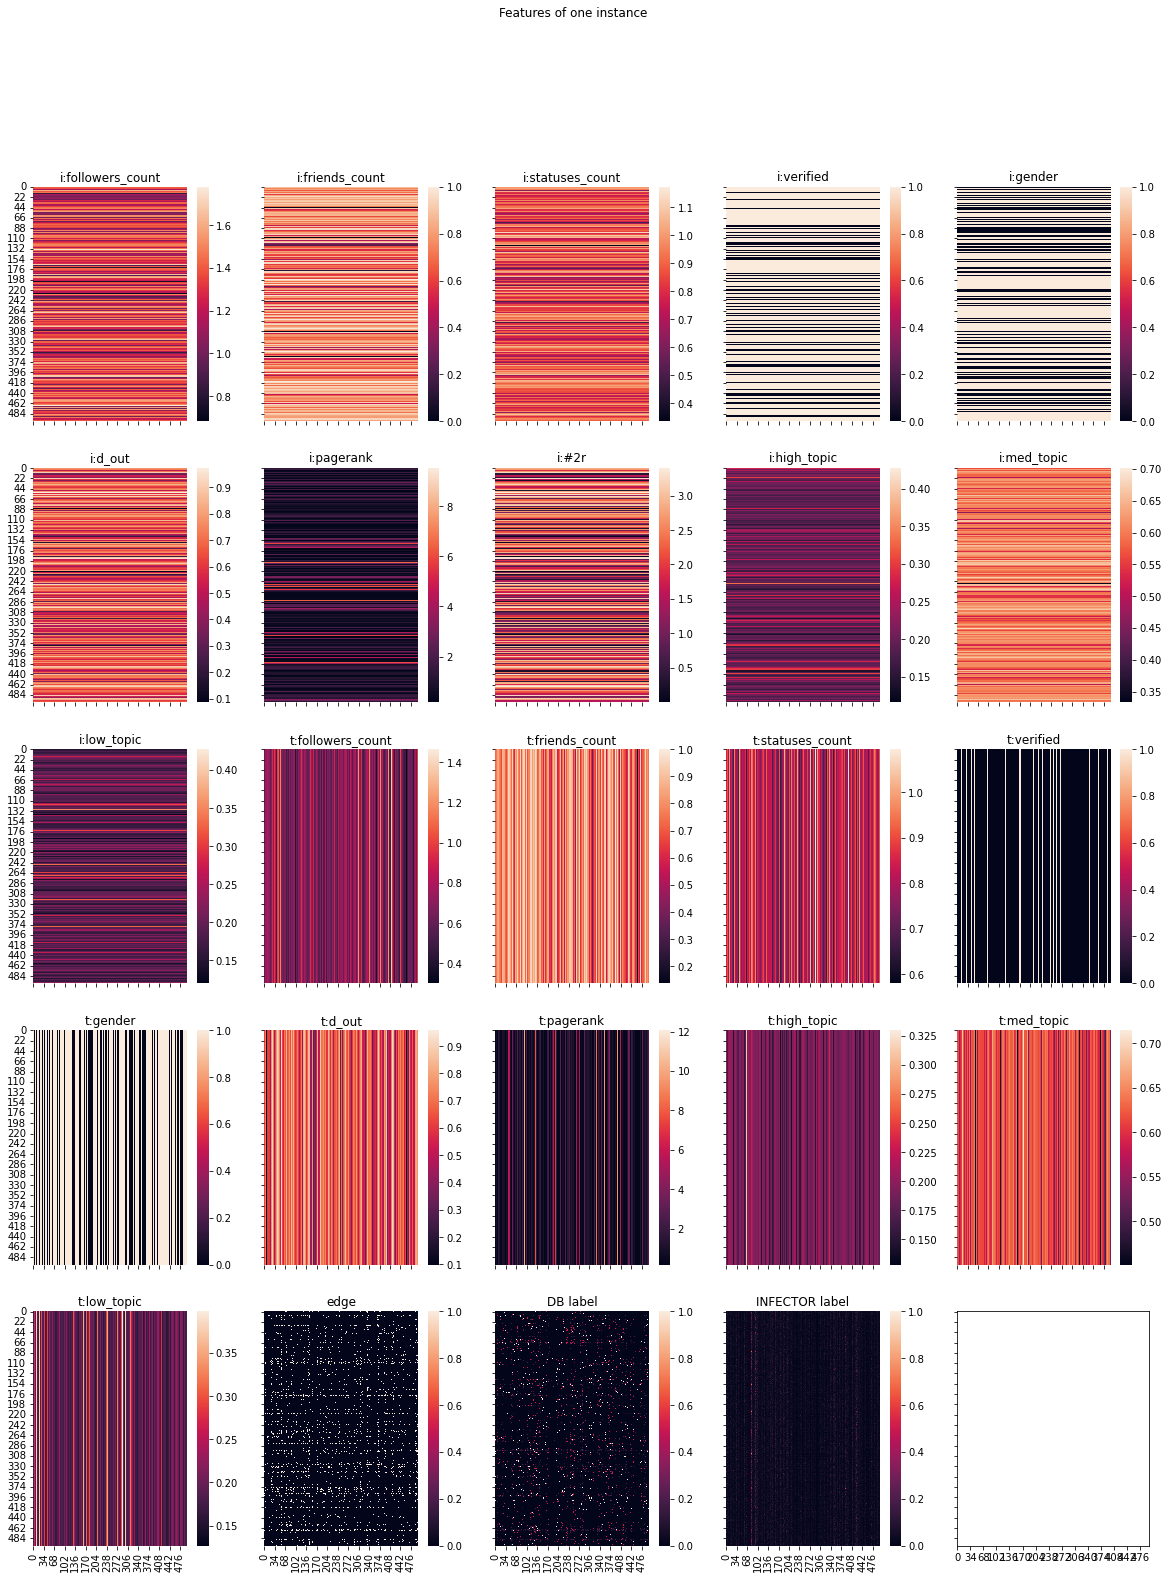

In [41]:
fig, axn = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,25))
# cbar_ax = fig.add_axes([.91, .3, .01, .4])

features = ['i:followers_count', 'i:friends_count', 'i:statuses_count', 'i:verified', 'i:gender', 'i:d_out', 'i:pagerank', 'i:#2r', 'i:high_topic', 'i:med_topic', 'i:low_topic', 't:followers_count', 't:friends_count', 't:statuses_count', 't:verified', 't:gender', 't:d_out', 't:pagerank', 't:high_topic', 't:med_topic', 't:low_topic', 'edge', 'DB label','INFECTOR label']
for i, ax in enumerate(axn.flat):
    if i < N_FEATURES :
        sns.heatmap(X_train[1,:,:,i], ax=ax,
                    # cbar=i == 0,
                    # vmin=0, vmax=1,
                    # cbar_ax=None if i else cbar_ax
                    )
        
    if i == N_FEATURES : 
        sns.heatmap(Y_train[1], ax=ax,
                # cbar=i == 0,
                # vmin=0, vmax=1,
                # cbar_ax=None if i else cbar_ax
                )
    if i == N_FEATURES + 1 :
        sns.heatmap(Yemb_train[1], ax=ax,
                    # cbar=i == 0,
                    # vmin=0, vmax=1,
                    # cbar_ax=None if i else cbar_ax
                    )
    if i < len(features) : 
        ax.set_title(features[i])

fig.suptitle("Features of one instance")
plt.show()


#### Plot of hidden layers weights

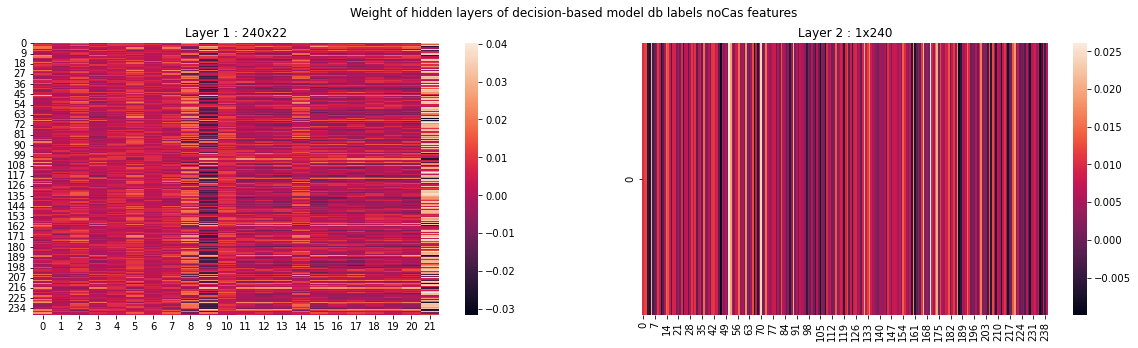

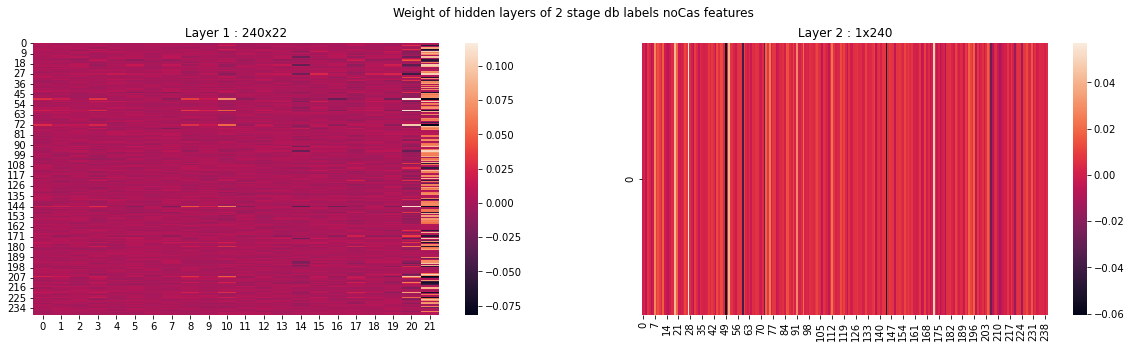

In [85]:
def print_hidden_layers(net, title) : 
    fig,ax = plt.subplots(1 , num_layers, figsize = (20,5))
    plt.suptitle(title)

    for i,ax in enumerate(ax.flat) :
        weights = net[3*i].weight.detach().cpu().numpy()
        sns.heatmap(weights, ax=ax)
        ax.set_title(f'Layer {i + 1} : {weights.shape[0]}x{weights.shape[1]}')
        
print_hidden_layers(net_df, 'Weight of hidden layers of decision-based model db labels noCas features')
print_hidden_layers(net_2s, f'Weight of hidden layers of 2 stage db labels noCas features')

#### Comparison between output of model and labels

NameError: name 'net_st' is not defined

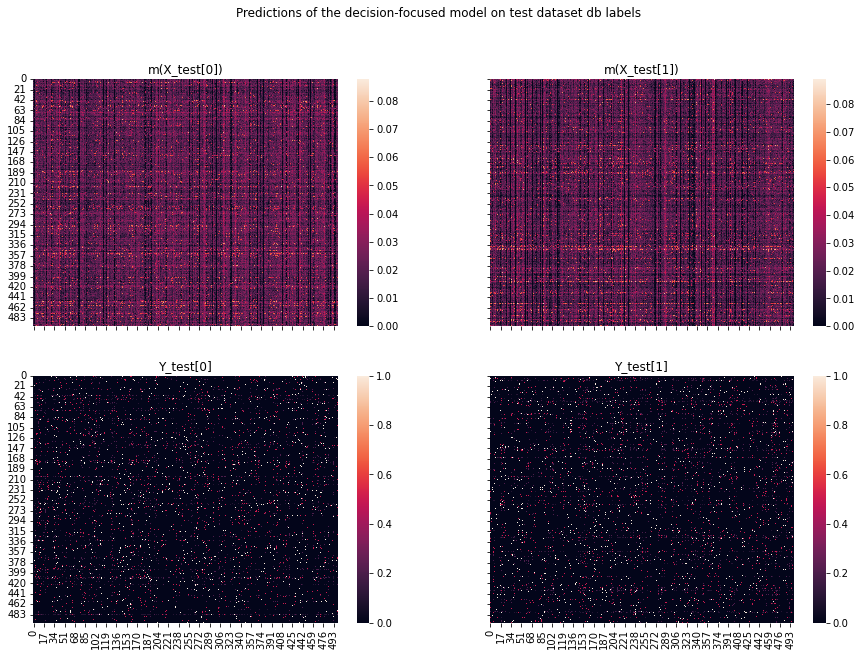

In [44]:
def print_output_test(net, title) :
    fig,ax = plt.subplots(2, 2, figsize = (15,10),sharex=True, sharey=True)
    # cbar_ax = fig.add_axes([.91, .3, .01, .4])
    # netcpu = copy.deepcopy(net).to('cpu')
    plt.suptitle(title)
    for i,ax in enumerate(ax.flat) :
        if i < 2 : 
            sns.heatmap(net(X_test[i].to(device)).view_as(Y_test[0]).detach().cpu(), 
                        ax=ax, 
                        # vmax = 1, 
                        # vmin = 0, 
                        # cbar_ax = None if i else cbar_ax,
                        # cbar=(i==0)
            )
            ax.set_title(f'm(X_test[{i}])')
        else : 
            sns.heatmap(Y_test[i-2], 
                        ax=ax, 
                        # vmax = 1, 
                        # vmin = 0, 
                        # cbar_ax = None if i else cbar_ax,
                        # cbar=(i==0)
            )
            ax.set_title(f'Y_test[{i-2}]')

print_output_test(net_df, "Predictions of the decision-focused model on test dataset db labels")
print_output_test(net_st, f"Predictions of the stochastic{nk} model on test dataset db labels")
print_output_test(net_2s, "Predictions of the 2-stage model on test dataset db labels")

#### Comparison of influence between models and random and greedy

In [52]:
def compare_grd(net,X,Y) : 
    pred = eval_grd(net, X,Y)
    X, Y = X.to(device), Y.to(device)
    th = np.mean([greedy(k, Y[i,:,:].to(device),w)[0].item() for i in range(X.shape[0])])
    del(X)
    del(Y)
    print(f"Influence of seeds returned by the model {pred}")
    print(f"Influence of seeds returned by the Oracle-Greedy {th}")
    
print("Decision_based on train dataset : ")
compare_grd(net_df, X_train, Y_train)
print("\n Decision_based on test dataset : ")
compare_grd(net_df, X_test, Y_test)
print("2-stage on train dataset : ")
compare_grd(net_2s, X_train, Y_train)
print("\n 2-stage on test dataset : ")
compare_grd(net_2s, X_test, Y_test)

Decision_based on train dataset : 
Influence of seeds returned by the model 292.6946678161621
Influence of seeds returned by the Oracle-Greedy 353.6588134765625

 Decision_based on test dataset : 
Influence of seeds returned by the model 299.44195556640625
Influence of seeds returned by the Oracle-Greedy 351.00914001464844
2-stage on train dataset : 
Influence of seeds returned by the model 297.66711807250977
Influence of seeds returned by the Oracle-Greedy 353.6588134765625

 2-stage on test dataset : 
Influence of seeds returned by the model 300.6870422363281
Influence of seeds returned by the Oracle-Greedy 351.00914001464844


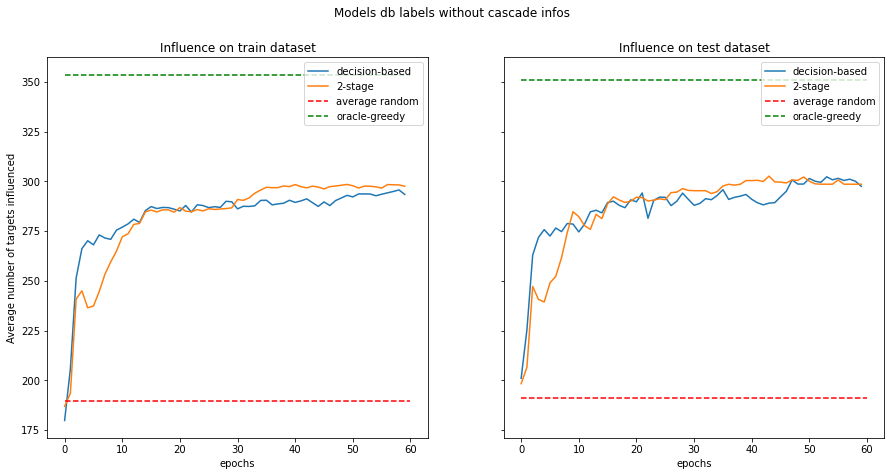

In [79]:
greedy_train = np.mean([greedy(k, Y_train[i,:,:].to(device),w)[0].item() for i in range(Y_train.shape[0])])
greedy_test = np.mean([greedy(k, Y_test[i,:,:].to(device),w)[0].item() for i in range(Y_test.shape[0])])

def compare_score_model(train_scores_df, test_scores_df, train_scores_2s, test_scores_2s, title="", rd_score_xtrain=0, rd_score_xtest=0):
    fig,ax = plt.subplots(1,2, figsize = (15,7), sharey=True)
    n = min(len(test_scores_2s),len(test_scores_df))

    ax[0].plot(train_scores_df[:n], label='decision-based')# ax = ax[0])
    ax[0].plot(train_scores_2s[:n], label='2-stage')# ax = ax[0])
    ax[0].hlines(y=rd_score_xtrain, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[0].hlines(y=greedy_train, xmin=0, xmax=n, linestyle='--', color='green', label='oracle-greedy')
    ax[0].legend(loc='upper right')
    ax[0].set_title("Influence on train dataset")
    ax[0].set_ylabel('Average number of targets influenced')
    ax[0].set_xlabel('epochs')

    ax[1].plot(test_scores_df[:n],label='decision-based')
    ax[1].plot(test_scores_2s[:n], label='2-stage')
    ax[1].hlines(y=rd_score_xtest, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[1].hlines(y=greedy_test, xmin=0, xmax=n, linestyle='--', color='green', label='oracle-greedy')
    ax[1].legend(loc='upper right')
    ax[1].set_title("Influence on test dataset")
    ax[1].set_xlabel('epochs')

    fig.suptitle(title)
    plt.show()

compare_score_model(train_scores_df,test_scores_df, train_scores_2s, test_scores_2s, "Models db labels without cascade infos", rd_score_xtrain, rd_score_xtest, )


In [66]:
perfk_df = []
perfk_2s = []
perfk_greedy = []
perfk_random = []
X_train = X_train.to(device)
Y_train = Y_train.to(device)
for k in range(0,N_INFLUENCERS,) : 
    if k % 50 == 0 : print(f"{k}/{N_INFLUENCERS}") 
    
    perfk_df.append(np.mean([set_func(greedy(k, net_df(X_train[i,:,:,:]).view_as(Y_train[0]), w)[1], Y_train[i, :, :], w) for i in range(X_train.shape[0])]))
    perfk_2s.append(np.mean([set_func(greedy(k, net_2s(X_train[i,:,:,:]).view_as(Y_train[0]), w)[1], Y_train[i, :, :], w) for i in range(X_train.shape[0])]))
    
    perfk_greedy.append(np.mean([set_func(greedy(k, Y_train[i, :, :], w)[1], Y_train[i, :, :], w) for i in range(Y_train.shape[0])]))
    perfk_random.append(np.mean([np.mean([set_func( random.sample(range(N_INFLUENCERS),k) , Y_train[i,:,:], w) for i in range(X_train.shape[0])]) for _ in range(2)]))
    

In [100]:
perfk_degrees = []
for k in range(0, N_INFLUENCERS,) : 
    perfk_degrees.append(np.mean([set_func(degree_seeds(k, X_train[i]), Y_train[i], w) for i in range(X_train.shape[0])]))

[]

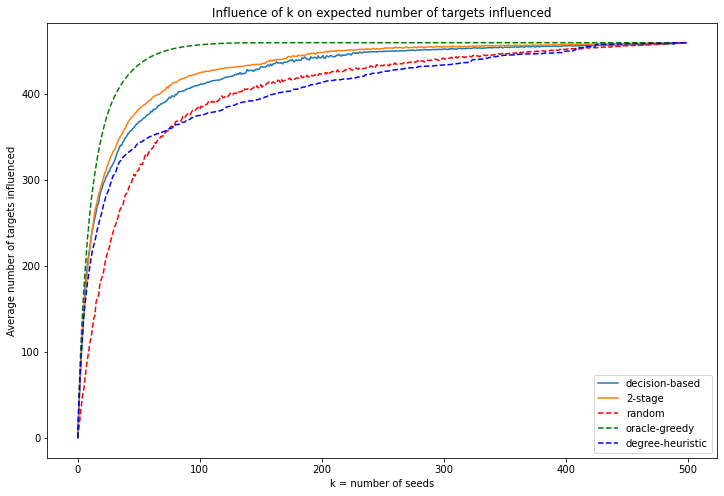

In [104]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(perfk_df, label='decision-based')# ax = ax[0])
ax.plot(perfk_2s, label='2-stage')# ax = ax[0])
ax.plot(perfk_random, linestyle='--', color='red', label='random')
ax.plot(perfk_greedy, linestyle='--', color='green', label='oracle-greedy')
ax.plot(perfk_degrees, linestyle='--', color='blue', label='degree-heuristic')

ax.legend(loc='lower right')
ax.set_title("Influence of k on expected number of targets influenced")
ax.set_ylabel('Average number of targets influenced')
ax.set_xlabel('k = number of seeds')

plt.plot()


In [80]:
dni_df = []
dni_2s = []
dni_greedy = []
dni_random = []
dni_degrees = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
def degree_seeds(k, X) : 
    """
    Returns the k influencers having the biggest d_out
    """
    return X[:,0,5].sort(descending=True).indices[:k]

for k in range(0,N_INFLUENCERS,3) : 
    if k % 50 == 0 : print(f"{k}/{N_INFLUENCERS}") 
    
    dni_df.append(np.mean([dni(greedy(k, net_df(X_train[i,:,:,:]).view_as(Y_train[0]), w)[1], Y_train[i,:,:]) for i in range(X_train.shape[0])]))
    dni_2s.append(np.mean([dni(greedy(k, net_2s(X_train[i,:,:,:]).view_as(Y_train[0]), w)[1], Y_train[i,:,:]) for i in range(X_train.shape[0])]))
    
    dni_greedy.append(np.mean([dni(greedy(k, Y_train[i, :, :], w)[1], Y_train[i, :, :]) for i in range(Y_train.shape[0])]))
    dni_random.append(np.mean([np.mean([dni(random.sample(range(N_INFLUENCERS),k) , Y_train[i,:,:]) for i in range(X_train.shape[0])]) for _ in range(10)]))
    dni_degrees.append(np.mean([dni(degree_seeds(k, X_train[i]), Y_train[i, :, :]) for i in range(Y_train.shape[0])]))

0/500
150/500
300/500
450/500


In [98]:
dni_degrees = []
for k in range(0,N_INFLUENCERS, 3) : 
    dni_degrees.append(np.mean([dni(degree_seeds(k, X_train[i]), Y_train[i, :, :]) for i in range(Y_train.shape[0])]))
    

[]

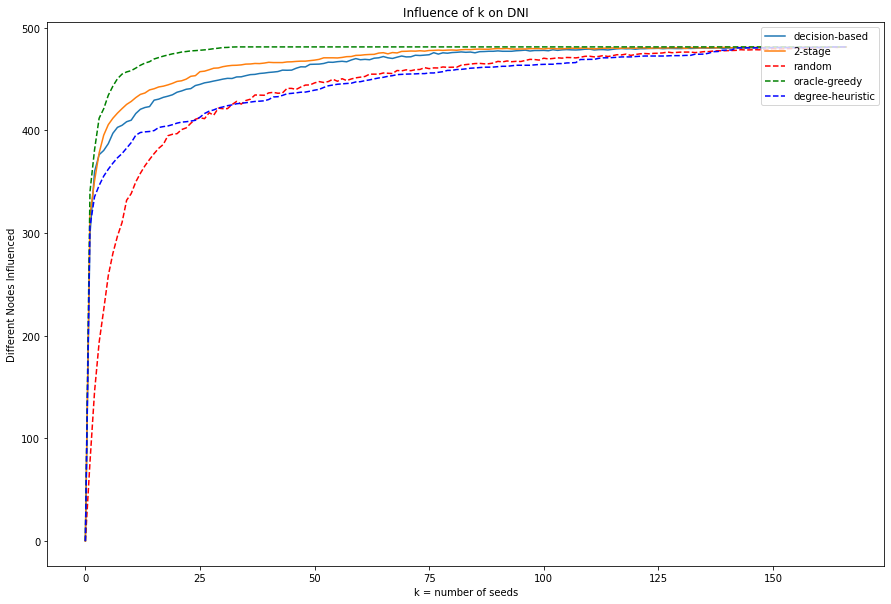

In [99]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(dni_df, label='decision-based')# ax = ax[0])
ax.plot(dni_2s, label='2-stage')# ax = ax[0])
ax.plot(dni_random, linestyle='--', color='red', label='random')
ax.plot(dni_greedy, linestyle='--', color='green', label='oracle-greedy')
ax.plot(dni_degrees, linestyle='--', color='blue', label='degree-heuristic')
ax.legend(loc='upper right')
ax.set_title("Influence of k on DNI")
ax.set_ylabel('Different Nodes Influenced')
ax.set_xlabel('k = number of seeds')

plt.plot()


### Saving models

In [55]:
torch.save(net_2s, "models/2s_all_200_noCas.pt")


end